# Evaluation
### 1. Export Model
Before the Model can be evaluated properly, it has to be exported from the most recent checkpoint. This is done by the `exporter_main_v2.py` script of the TensorFlow object detection API

In [1]:
exporter_main_v2_path = '/home/dammeier@ab.ba.ba-ravensburg.de/dev/oil-storage-detection/scripts/exporter_main_v2.py'
trained_checkpoint_dir_path = '/home/dammeier@ab.ba.ba-ravensburg.de/dev/oil-storage-detection/data/06_models/models/ssd_resnet101_1024/checkpoint/'
pipeline_config_path = '/home/dammeier@ab.ba.ba-ravensburg.de/dev/oil-storage-detection/data/06_models/models/ssd_resnet101_1024/pipeline.config'
output_directory_path = '/home/dammeier@ab.ba.ba-ravensburg.de/dev/oil-storage-detection/data/06_models/models/ssd_resnet101_1024/'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [3]:
!python {exporter_main_v2_path} \
    --trained_checkpoint_dir {trained_checkpoint_dir_path} \
    --output_directory {output_directory_path} \
    --pipeline_config_path {pipeline_config_path}

Traceback (most recent call last):
  File "/home/dammeier@ab.ba.ba-ravensburg.de/dev/oil-storage-detection/scripts/exporter_main_v2.py", line 104, in <module>
    from object_detection import exporter_lib_v2
  File "/home/zengerle@ab.ba.ba-ravensburg.de/bash/envs/DeepLearning/lib/python3.9/site-packages/object_detection/exporter_lib_v2.py", line 21, in <module>
    from object_detection.builders import model_builder
  File "/home/zengerle@ab.ba.ba-ravensburg.de/bash/envs/DeepLearning/lib/python3.9/site-packages/object_detection/builders/model_builder.py", line 22, in <module>
    from object_detection.builders import box_predictor_builder
  File "/home/zengerle@ab.ba.ba-ravensburg.de/bash/envs/DeepLearning/lib/python3.9/site-packages/object_detection/builders/box_predictor_builder.py", line 20, in <module>
    from object_detection.predictors import convolutional_box_predictor
  File "/home/zengerle@ab.ba.ba-ravensburg.de/bash/envs/DeepLearning/lib/python3.9/site-packages/object_detect

## 2. Recap of the Model Training

### Model Information
We trained a SSD (Single Stage Detector) model using a Resnet101 Backbone and a 1024x1024 input layer on quatered input images (resulting in a size of 1280x1280) for the input images. The images thus had to be slightly scales during model training. The model is pretrained on COCO-2017 using the checkpoints provided in the TensorFlow model Zoo. We use a batch size of four on four GPUs, a learning rate of 0.0025 with momentum optimizer and a toal of 15000 steps (=trained Batches).

### Training Progress
Before we actually test the final model on single images and the test dataset, let's first discuss what information can be obtained from the TensorBoard tracking information during model training.

In [1]:
# Run TensorBoard in notebook
%load_ext tensorboard
%tensorboard --logdir /home/dammeier@ab.ba.ba-ravensburg.de/dev/oil-storage-detection/data/06_models/models/ssd_resnet101_1024/v2

Reusing TensorBoard on port 6006 (pid 1644137), started 12:16:09 ago. (Use '!kill 1644137' to kill it.)

### Training Progress Analysis
A few interesting things can be told from the training graphs. First, lets explain some basics. The orange graphs show the metrics calculated from the performance on the train dataset. The blue graphs are on the eval dataset. It is clear that all the loss values are much lower on the training set than on the validation set, which suggests bad generalization capabilitie of the model, but we will have to look into that later. Interesting are the graphs depicting the different components of the COCO detection metrics (mAP) which was introduced in the training notebook. It is clear that the performance on the validation set reaches a maximum after about 15000 training steps after which it drops again, suggesting overfitting. It can also be observed that the filter for large objects that is provided by the COCO detection API is constantly at -1 mAP which means that the dataset does not contain any large objects. This is in line with the findings in the EDA notebook. 


## 2. Test trained model on test images

In [7]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

In [8]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: a file path (this can be local or on colossus)

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [9]:
labelmap_path = '/home/dammeier@ab.ba.ba-ravensburg.de/dev/oil-storage-detection/data/04_feature/annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

In [12]:
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2022-05-27 14:38:29.833174: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-27 14:38:31.069419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 510 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [13]:
tf.keras.backend.clear_session()

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
model = tf.saved_model.load(f'{output_directory_path}/saved_model')

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 35.08612012863159 seconds


In [14]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
test_images_path = '/home/zengerle@ab.ba.ba-ravensburg.de/airplane_detection/TensorFlow/workspace/training_demo/images/test/*jpg'

with strategy.scope():
    for image_path in glob.glob(test_images_path):
        image_np = load_image_into_numpy_array(image_path)
        output_dict = run_inference_for_single_image(model, image_np)
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks_reframed', None),
            use_normalized_coordinates=True,
            line_thickness=8)
        display(Image.fromarray(image_np))

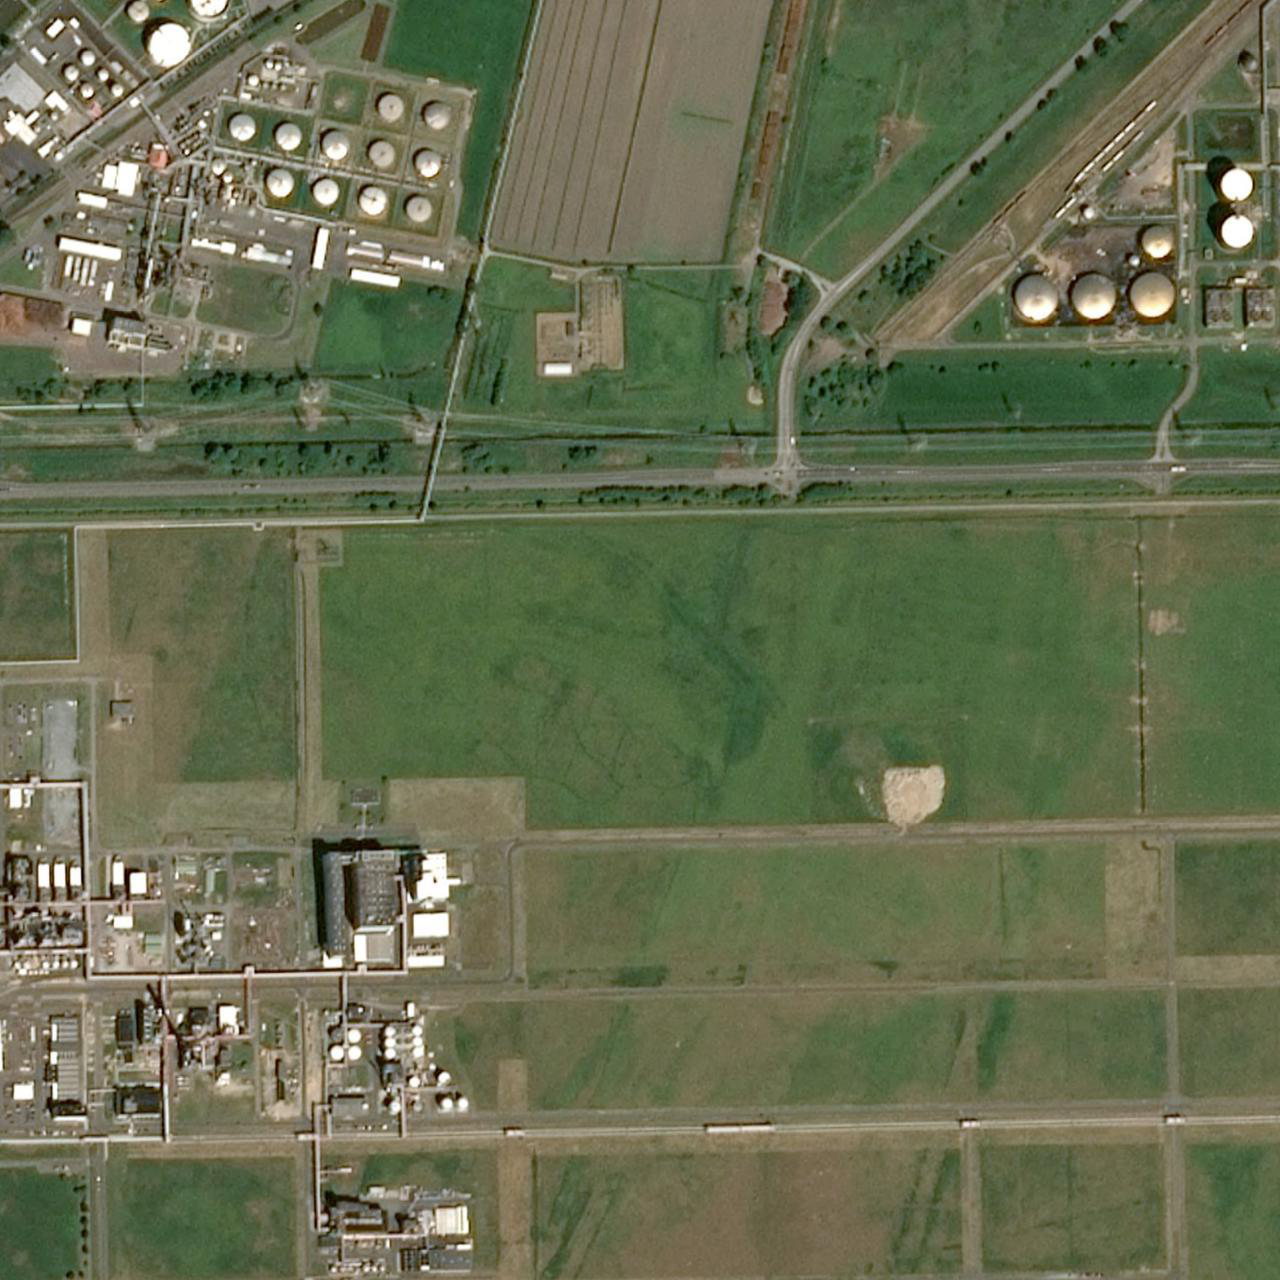

In [19]:
test_images_path = '/home/dammeier@ab.ba.ba-ravensburg.de/dev/oil-storage-detection/data/04_feature/images/test/*jpg'

image_paths = glob.glob(test_images_path)

image_path = image_paths[3]

#for image_path in glob.glob(test_images_path):
image_np = load_image_into_numpy_array(image_path)
output_dict = run_inference_for_single_image(model, image_np)
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8)
display(Image.fromarray(image_np))